In [18]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.regularizers import L1, L2, L1L2
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [19]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [20]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 6000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

x_train = x_train[:, 0:600, :, :]
x_valid = x_valid[:, 0:600, :, :]
X_test = X_test[:, 0:600, :, :]

print(x_train.shape)

(7915, 22, 1000)
(7915,)
(7915, 600, 1, 22)


# Approach 2: Vanilla CNN with More Layers
This initial architecture can serve as a starting point, consisting solely of convolution and pooling layers, followed by a single softmax dense layer similar to the architecture used before. One thing to note is that the convolution and pooling kernels are essentially single-dimensional (e.g. 20 x 1) due to the input being time-series data. The rationale here is that there should be more emphasis on data in *succession* (e.g. a line) rather than data in a *region* (e.g. a square/rectangle). Unlike the previous model, this model is making use of *more* parameters (larger number of filters) with the hope of increasing training accuracy beyond just 80% (and potentially the validation accuracy increasing as a result). 

In [21]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=20, kernel_size=(20, 1), padding='same', activation='relu', input_shape=(600, 1, 22)))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

cnn_model.add(Conv2D(filters=50, kernel_size=(15, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

cnn_model.add(Conv2D(filters=100, kernel_size=(15, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

cnn_model.add(Conv2D(filters=200, kernel_size=(5, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))


cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

cnn_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 600, 1, 20)        8820      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 200, 1, 20)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 200, 1, 20)        80        
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 200, 1, 20)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 200, 1, 50)        15050     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 67, 1, 50)        

In [22]:
learning_rate = 1e-3
epochs = 200
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [23]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/200
124/124 [==============================] - 5s 39ms/step - loss: 2.1381 - accuracy: 0.3065 - val_loss: 1.3554 - val_accuracy: 0.3550
Epoch 2/200
124/124 [==============================] - 5s 38ms/step - loss: 1.7086 - accuracy: 0.3414 - val_loss: 1.3028 - val_accuracy: 0.3900
Epoch 3/200
124/124 [==============================] - 5s 39ms/step - loss: 1.4276 - accuracy: 0.4062 - val_loss: 1.3129 - val_accuracy: 0.3500
Epoch 4/200
124/124 [==============================] - 5s 40ms/step - loss: 1.2909 - accuracy: 0.4623 - val_loss: 1.2322 - val_accuracy: 0.4100
Epoch 5/200
124/124 [==============================] - 5s 38ms/step - loss: 1.1996 - accuracy: 0.5025 - val_loss: 1.1265 - val_accuracy: 0.4650
Epoch 6/200
124/124 [==============================] - 6s 45ms/step - loss: 1.1374 - accuracy: 0.5267 - val_loss: 1.3274 - val_accuracy: 0.4150
Epoch 7/200
124/124 [==============================] - 5s 42ms/step - loss: 1.1057 - accuracy: 0.5443 - val_loss: 1.0729 - val_accuracy:

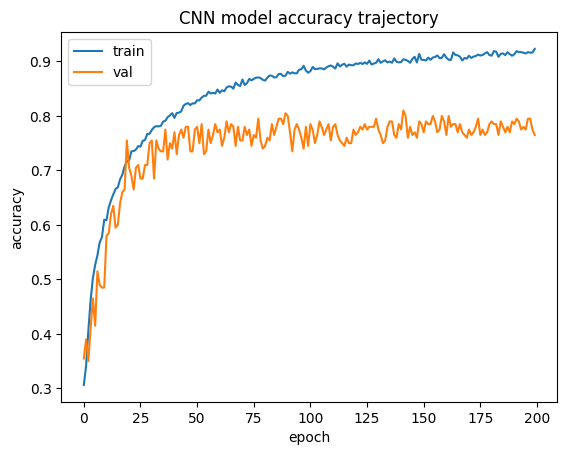

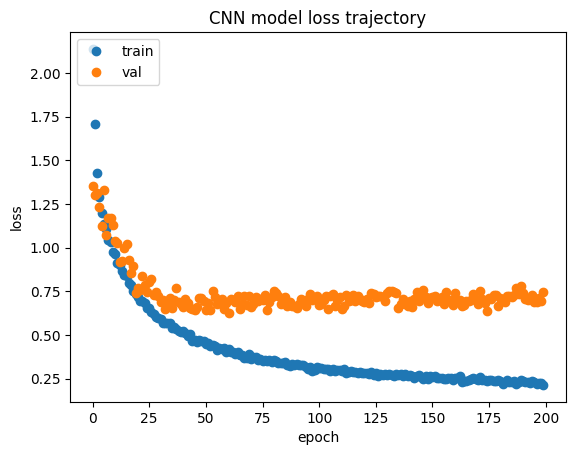

In [24]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
cnn_model_score_all_subjects = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=cnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.7381489872932434


In [26]:
# Test the model against each individual subject group
for i in range(9):
  indices = np.where(person_test[:, 0] == i)
  x = X_test[indices]
  y = y_test[indices]
  score = cnn_model.evaluate(x, y, verbose=0)
  print("Subject {subject} Accuracy: {score}".format(subject=i, score=score[1]))

Subject 0 Accuracy: 0.699999988079071
Subject 1 Accuracy: 0.6200000047683716
Subject 2 Accuracy: 0.7599999904632568
Subject 3 Accuracy: 0.7599999904632568
Subject 4 Accuracy: 0.7659574747085571
Subject 5 Accuracy: 0.7346938848495483
Subject 6 Accuracy: 0.7200000286102295
Subject 7 Accuracy: 0.7400000095367432
Subject 8 Accuracy: 0.8510638475418091
